In [1]:
%reload_ext autoreload
from env import SingleStateSpace 
from generate_trajectory import generate_trajectory
from policy import Boltzmann 
from learn import compute_q_with_values
from RewardFunctions import SingleStateReward
import numpy as np 
from learn import policy_iteration
from utils import normalise_pi
from policy_walk import policy_walk 
import matplotlib.pyplot as plt 

In [4]:
#Set up the environment
trajectory_length = 20 
env = SingleStateSpace(n_actions = 10, discount_rate = 0.1, R_max = 5)

#generate observation times 
observation_times = np.cumsum(np.random.uniform(0, 2, size=trajectory_length))
print("Generated observation times:") 
print(observation_times)

#Create a matrix for the true rewards 
s_grid, a_grid, t_grid = np.meshgrid(env.states, env.actions, observation_times, indexing='ij')
R = np.vectorize(env.reward)(s_grid,a_grid,t_grid)

#Find the optimal policy, values and q_values for the true reward to generate the trajectory. 
(optimal_pi, optimal_values, optimal_q_values) = policy_iteration(env,trajectory_length,R)
b = Boltzmann(optimal_q_values, env.actions, alpha = 100)

#multiple trajectories are combined - just means that the agent does multiple things at each time slot to allow for more data to be gathered
observations = generate_trajectory(env,b,observation_times, n_trajectories=1) 
from policy_walk import calculate_likelihood
print(calculate_likelihood(env,observations,20,R))

#Sample from policy walk - I discard the first half of each policy walk iteration.
learned_rewards = policy_walk(env,observations,n_observations = trajectory_length,n_iters=10000)[5000:10000]
policy_walk_iters = 5
for _ in range(policy_walk_iters-1): 
    learned_rewards = np.concatenate((learned_rewards, policy_walk(env,observations,n_observations = trajectory_length,n_iters=10000)[5000:10000]))

Generated observation times:
[ 0.67058276  2.03663769  2.27511781  4.2708139   6.10180286  6.26841801
  6.9995678   7.68874261  8.321607   10.18490521 10.34224008 12.14987547
 12.76003747 13.47082371 14.79076739 15.02159373 15.13981142 16.46874975
 16.61130751 17.03309918]
0.5734504751808172


[ 0.67058276  2.03663769  2.27511781  4.2708139   6.10180286  6.26841801
  6.9995678   7.68874261  8.321607   10.18490521 10.34224008 12.14987547
 12.76003747 13.47082371 14.79076739 15.02159373 15.13981142 16.46874975
 16.61130751 17.03309918]


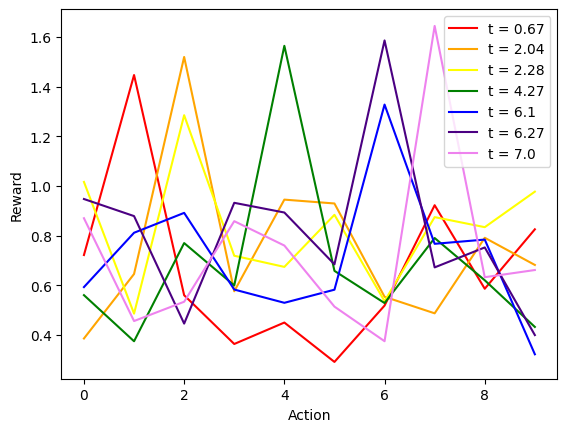

In [5]:
#Used to analyse the learned rewards
# colors = ["#e71d43","#ff0000","#ff3700","#ff6e00","#ffa500","#ffc300","#ffe100","#ffff00","#aad500","#55aa00","#008000","#005555","#002baa","#0000ff","#1900d5","#3200ac","#4b0082","#812ba6","#b857ca","#d03a87"]
avg_reward = np.average(np.asarray(learned_rewards),axis = 0)
print(observation_times)
colors = ["red", "orange","yellow","green","blue","indigo","violet"]
for t in range(7):
    label = "t = " + format(round(observation_times[t],2))
    plt.plot(avg_reward[0,:,t], color=colors[t], label = label)
plt.ylabel("Reward")
plt.xlabel("Action")
plt.legend()
plt.show()

In [50]:
learned_rewards = np.asarray(learned_rewards)

To do meaningful chain analysis, you need to just do one policy walk really. The chain never seems to converge, but it does usually go up when there is an observation and walks randomly otherwise.

[[0, 1, 0], [0, 2, 1], [0, 2, 2], [0, 4, 3], [0, 6, 4], [0, 6, 5], [0, 7, 6], [0, 8, 7], [0, 8, 8], [0, 9, 9], [0, 9, 10], [0, 8, 11], [0, 7, 12], [0, 7, 13], [0, 5, 14], [0, 5, 15], [0, 5, 16], [0, 4, 17], [0, 3, 18], [0, 3, 19]]


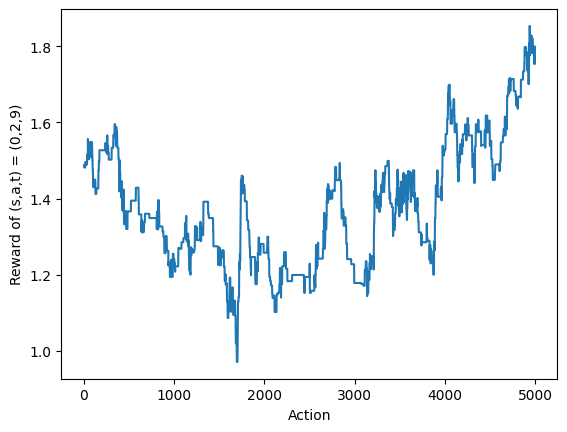

In [10]:
#Used to analyse individual chains: 
print(observations)

#Plot a single reward
s,a,t = 0,2,9
plt.plot(learned_rewards[:,s,a,t][0:5000])
ylabel = "Reward of (s,a,t) = (" + format(s) + "," + format(a) + "," + format(t) + ")"
plt.ylabel(ylabel)
plt.xlabel("Action")
plt.show()

[[0, 1, 0], [0, 3, 1], [0, 4, 2], [0, 5, 3], [0, 6, 4], [0, 7, 5], [0, 8, 6], [0, 8, 7], [0, 9, 8], [0, 9, 9], [0, 8, 10], [0, 7, 11], [0, 6, 12], [0, 6, 13], [0, 4, 14], [0, 4, 15], [0, 2, 16], [0, 1, 17], [0, 0, 18], [0, 2, 19]]


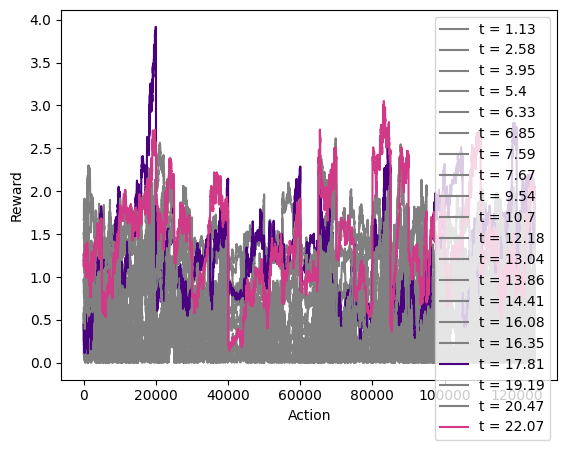

<Figure size 1600x1600 with 0 Axes>

In [68]:
#Plot rewards over time for a given action 
print(observations)
s,a, = 0,2
# s,t = 0,5

for t in range(20):
    label = "t = " + format(round(observation_times[t],2))
    # label =  "a = " + format(a)
    if [s,a,t] in observations: 
        plt.plot(learned_rewards[:,s,a,t], color=colors[t], label = label)
    else:
        plt.plot(learned_rewards[:,s,a,t], color="grey", label = label)        
    
plt.ylabel("Reward")
plt.xlabel("Action")
plt.legend()
plt.figure(figsize=(10,10), dpi=160)
plt.show()